In [89]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gensim
import spacy
import nltk

from sentimentpl.models import SentimentPLModel
import matplotlib.pyplot as plt

import re
import unicodedata
from langdetect import detect
import torch


from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append('..')

from helpers.dataset import (
    tokenize,
    filter_stop_words,
    deal_with_polish_sign,
    clean_text,
    get_stylometric_features
)

from transformers import AutoTokenizer, AutoModel

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
stopwords = nlp_core.Defaults.stop_words

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# !pip install langdetect

# Read data & clean text

In [45]:
#demagog
df_dem = pd.read_csv('../datasets/scrapped/demagog.csv', sep=';')

df_dem = df_dem.dropna()
df_dem = df_dem[df_dem['text'].str.len() > 0 ]

# oko press
df_oko_raw = pd.read_csv('../datasets/oko.press/query_result.tsv', sep='\t')

df_oko = pd.merge(
    df_oko_raw.pivot(index=['Id wypowiedzi'], columns='Nazwa pola danych', values='Wartość pola danych').reset_index(),
    df_oko_raw[~df_oko_raw['Autor Wypowiedzi'].isin(['Link do hasła', 'Nazwa słupka', 'Wesprzyj nas'])] \
        [['Id wypowiedzi', 'Autor Wypowiedzi']].dropna(),
    on='Id wypowiedzi',
    how='left'
)

df_oko_fin = df_oko[['sub_napis', 'sub_stan_zegara', 'Autor Wypowiedzi']]
df_oko_fin = df_oko_fin.rename(columns={'sub_napis':'text', 'sub_stan_zegara':'assestment', 'Autor Wypowiedzi':'author'})


# combine both
df = pd.concat(
    [
        df_dem[['assestment', 'author', 'text']],
        df_oko_fin[['assestment', 'author', 'text']],
    ],
    ignore_index = True
)


# start cleaning
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
df['text_clean'] = df['text_clean'].apply(lambda x: deal_with_polish_sign(x))

df = df[df['text_clean'].str.len() > 1 ]

# Filter not TRUE/FALSE cases

In [46]:
df['assestment'].value_counts()

assestment
Prawda               2831
falsz                1308
Fałsz                1136
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
brak                   40
Częściowy fałsz       9
Name: count, dtype: int64

In [47]:
df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 1,
    'Prawda' : 0
}).astype(int)

df = df.reset_index(drop=True)

## Detect other languages

In [48]:
df['lang'] =  df['text_clean'].progress_apply(lambda x: detect(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6542/6542 [00:08<00:00, 805.32it/s]


In [51]:
df['lang'].value_counts()

lang
pl    6531
en       6
es       2
tr       1
tl       1
sl       1
Name: count, dtype: int64

In [54]:
df[['lang', 'text_clean']][~df['lang'].isin(['pl'])].sort_values('lang')

,lang,text_clean
447,en,Gastronomia? 2 mld straty.
2084,en,Funding from ECA supports national export of g...
2085,en,Sweden has recently resigned from a penalty ta...
2186,en,The Poles consume only 50% of electrical power...
2187,en,Energy accounts for 10% of a citizen’s expense...
2188,en,85% of the energy still comes from coal.
1363,es,Los Angeles albo San Francisco ma 22 radnych.
5899,es,Ma dobre poglądy o Ursuli von der Leyen - red..
3611,sl,Spada od kilku lat podatek CIT dla miasta
2864,tl,Sama ustawa o VAT ma 25000 stron.


In [56]:
df = df[df['lang'].isin(['pl', 'sl', 'tl', 'es'])]

## Continue with cleaning text

In [57]:
df['words'] = df['text_clean'].progress_apply(
    lambda x: tokenize(x, nlp_core, stopwords, join_str=None)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6535/6535 [00:48<00:00, 134.84it/s]


In [60]:
# df = df[df['words'].apply(len)>0]

# Look for more stopwords

In [61]:
df_one = df.copy()

df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

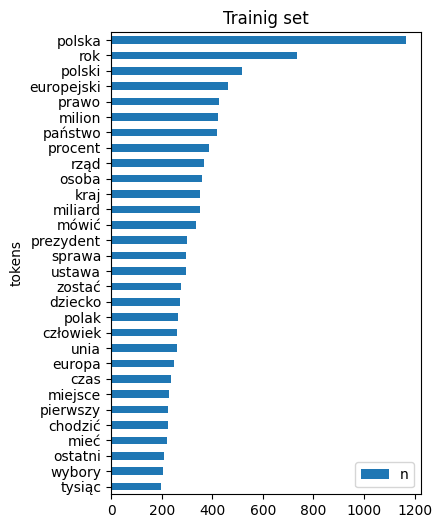

In [62]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(4,6));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

In [63]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'milion',]
                        # 'miliard',] 
                        # 'polski', 'europejski', 
                        # 'prezydent', 'rząd', 'ustawa', 'procent', 'kraj'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [64]:
len(extra_stop_words)

10389

In [65]:
df['words_clean'] = df['words'].progress_apply(
    lambda x: filter_stop_words(x, extra_stop_words, ' ')
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6535/6535 [00:00<00:00, 347354.92it/s]


## Delete rows without  any words

In [66]:
(df['words_clean'].str.len() == 0).sum()

6

In [67]:
df = df[df['words_clean'].str.len() > 0].reset_index(drop=True)

# Stylommetric features

In [69]:
df = get_stylometric_features(df,  nlp_core, model_sent, stopwords, 'words_clean', rerun_all=True)

## Get lexical features ##


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:00<00:00, 52435.53it/s]


## Vocab richness ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:35<00:00, 181.87it/s]


## Readability ##


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:00<00:00, 56137.98it/s]


## Add Sentiment ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [09:54<00:00, 10.98it/s]


## Extra features ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:36<00:00, 178.64it/s]


## Add WORDS ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:37<00:00, 176.26it/s]


## Add POS ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:36<00:00, 180.41it/s]


In [70]:
df.shape

(6529, 38)

## Save stylommetric features

In [71]:
target_column = ['assestment']

stylo_features = [
    'avg_word_len',
    'n_words', 'n_unique_words', 'p_unique_words', 'n_char',
    'n_special_char', 'avg_n_vowels_per_word', 'hapax_legomena',
    'hapax_dislegemena', 'honore_r', 'sichel_s', 'brunet_w', 'yule_k',
    'shannon_entropy', 'simpson_idx_d', 'type_token_ratio', 'FR_score',
    'FKG_level', 'Gunning_Fog_index', 'sentiment_all', 'sentiment_avg',
    'n_stop_words', 'n_ent', 'p_adj', 'n_adj', 'p_adv', 'n_adv', 'p_noun',
    'n_noun',
]

cols_for_other_f = ['text_clean', 'TEXT_WORD', 'TEXT_POS']

In [72]:
len(stylo_features)

29

In [73]:
df[target_column+stylo_features].to_parquet('../datasets/used_data/02_classical_ml/03_01_statements_styllometric_features.parquet')

# Ngrams POS

In [74]:
n_grams = 5
min_pos = 5 

In [75]:
df_pos = df[target_column].copy()

words =  sum(df['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_POS'].str.count(' '.join(n)) / df['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_pos = pd.concat( [df_pos] + list( col.values() ), axis=1 )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2646/2646 [00:32<00:00, 82.56it/s]


In [76]:
df_pos.shape

(6529, 2647)

In [77]:
df_pos.to_parquet('../datasets/used_data/02_classical_ml/03_02_statements_POS_ngrams.parquet')

# Ngram words

In [78]:
df_ngram = df[target_column + ['TEXT_WORD']].copy()

words =  sum(df['TEXT_WORD'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()

col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_WORD'].str.count(' '.join(n)) / df['TEXT_WORD'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_ngram = pd.concat( [df_ngram] + list( col.values() ), axis=1 )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [00:42<00:00, 65.38it/s]


In [79]:
df_ngram.shape

(6529, 2771)

In [80]:
df_ngram.to_parquet('../datasets/used_data/02_classical_ml/03_03_statements_words_ngrams.parquet')

# HerBERT embeddgins

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [93]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model = AutoModel.from_pretrained("allegro/herbert-large-cased").to(device)

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
embeddings_table = np.zeros((df.shape[0], 1024))

for i, t in enumerate(tqdm(df['text_clean'].values)):
    encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
    output = model(**encoded_input)[0][:,0]
    embeddings_table[i,:] = output.detach().to('cpu').numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [02:54<00:00, 37.38it/s]


In [95]:
with open('../datasets/used_data/02_classical_ml/03_04_statements_herbert.npy', 'wb') as f:
    np.save(f, embeddings_table)

# RoBERTa embeddgins

In [96]:
tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-large-v2")
model = AutoModel.from_pretrained("sdadas/polish-roberta-large-v2").to(device)

tokenizer_config.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.59M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at sdadas/polish-roberta-large-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
embeddings_table = np.zeros((df.shape[0], 1024))

for i, t in enumerate(tqdm(df['text_clean'].values)):
    encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
    output = model(**encoded_input)[0][:,0]
    embeddings_table[i,:] = output.detach().to('cpu').numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [03:02<00:00, 35.85it/s]


In [98]:
with open('../datasets/used_data/02_classical_ml/03_05_statements_roberta.npy', 'wb') as f:
    np.save(f, embeddings_table)

# Save just text after cleanings

In [100]:
df[['assestment', 'text', 'text_clean']].to_parquet('../datasets/used_data/03_bert_like_models/01_basic_info_data.parquet')